<a href="https://colab.research.google.com/github/omarkapur-mids/w266-project/blob/phillip/DROP/T5_DROP_Custom_Learning_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
save_model = False
load_model = False
train_model = True
use_learning_schedule = False
save_preprocessing = True #add
load_preprocessing = False #add
save_results = False
predict_train = False
predict_dev = True

run_toy = True
toy_size = 100
epochs = 3
batch_size = 8
dataset='squad' #acceptable values: drop, squad
VERSION="drop_only-v1"
t5_model = 't5-small'

warmup_steps = 10 #1e4
encoder_max_len = 250
decoder_max_len = 54
buffer_size = 1000

# Using T5 on DROP

#### Package installs

In [2]:
!pip install --quiet transformers
!pip install --quiet sentencepiece
!pip install --quiet wget
!pip install --quiet datasets
#!pip install --quiet ipywidgets
#!pip install --quiet tensorflow

#### Download drop_eval module and set directories

https://github.com/allenai/allennlp-reading-comprehension/blob/master/allennlp_rc/eval/drop_eval.py

In [3]:
!wget https://raw.githubusercontent.com/allenai/allennlp-reading-comprehension/master/allennlp_rc/eval/drop_eval.py -O drop_eval.py
import os
def create_dir(d,verbose=False):
    if not os.path.exists(d):
        !mkdir -p $d    
        if verbose: print(f'created folder for {d}')
    else:
        if verbose: print(f'using existing folder for {d}\nCAUTION -- this run may overwrite existing data!')
    
#set directories
root_dir = './data'
data_dir = f"./data/{VERSION}/{t5_model}"
processed_dir = f"{root_dir}/processed-data"
results_dir = f"{data_dir}/results/"
log_dir = f"{data_dir}/experiments/logs"
save_path = f"{data_dir}/experiments/models"


create_dir(root_dir)
create_dir(data_dir)
create_dir(processed_dir)
create_dir(results_dir)
create_dir(log_dir)
create_dir(save_path)

--2021-07-18 17:28:10--  https://raw.githubusercontent.com/allenai/allennlp-reading-comprehension/master/allennlp_rc/eval/drop_eval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11222 (11K) [text/plain]
Saving to: ‘drop_eval.py’

drop_eval.py        100%[===================>]  10.96K  --.-KB/s    in 0s      

2021-07-18 17:28:10 (39.0 MB/s) - ‘drop_eval.py’ saved [11222/11222]



#### load packages

In [4]:
# import warnings
# warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')


# import logging
# logging.getLogger("tensorflow").setLevel(logging.ERROR)
# logging.getLogger("tensorflow").addHandler(logging.NullHandler(logging.ERROR))
import os
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow.keras as keras
import drop_eval
import pandas as pd
import numpy as np
import json
from datasets import Dataset, load_dataset
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import datetime
import re

from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm,trange

%load_ext tensorboard

assert len(tf.config.list_physical_devices("GPU")) > 0, "No GPU found by Tensorflow"

if(run_toy): print(f'Running on {toy_size:,} records for development run')
    
!nvcc -V

Running on 100 records for development run
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


#### Define model class

In [5]:

class T5forDrop(TFT5ForConditionalGeneration):
    def __init__(self, *args, log_dir=None, cache_dir= None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker= tf.keras.metrics.Mean(name='loss')
        self.F1_tracker= tf.keras.metrics.Mean(name='F1')
        self.EM_tracker= tf.keras.metrics.Mean(name='EM')        

    
    @tf.function
    def train_step(self, data):
        x = data
        y_true = x["labels"]
        with tf.GradientTape() as tape:
            outputs = self(x, training=True)
            logits = outputs['logits']
            y_pred = tf.math.argmax(tf.nn.softmax(logits,axis=2), axis = 2, output_type=tf.int32)
            loss = tf.reduce_mean(outputs['loss'])            
            grads = tape.gradient(loss, self.trainable_variables)

        # Calculate F1 and EM Metrics
        # Create a word mask to not count the padding/sentence tokens
        recall_word_mask = tf.math.logical_and(
                    tf.math.not_equal(y_true,0)
                    ,tf.math.not_equal(y_true,1))

        precision_word_mask = tf.math.logical_and(
                    tf.math.not_equal(y_pred,0)
                    ,tf.math.not_equal(y_pred,1))

        # match the tokens
        match_token = tf.math.equal(y_true,y_pred)
        recall_match = tf.math.logical_and(match_token,recall_word_mask) 
        precision_match = tf.math.logical_and(match_token,precision_word_mask) 

        # calculate score
        precision_array = tf.math.reduce_sum(tf.cast(precision_match, tf.int32) ,axis=1)/tf.math.reduce_sum(tf.cast(precision_word_mask, tf.int32) ,axis=1)
        recall_array = tf.math.reduce_sum(tf.cast(recall_match, tf.int32) ,axis=1)/tf.math.reduce_sum(tf.cast(recall_word_mask, tf.int32) ,axis=1)

        P = tf.math.reduce_mean(precision_array)
        R = tf.math.reduce_mean(recall_array)

        EM = tf.math.reduce_mean(
            tf.cast(tf.math.logical_and(
                    tf.math.equal(precision_array,1)
                    ,tf.math.equal(recall_array,1)), tf.int32))
        F1 = 2*(P*R)/(P+R)
        
        '''
        Note, since FP and FN are the same, 
        the F1 score is the same as Precision, Recall, 
        which is the average "match" score
        '''

        y_true = tf.reshape(y_true, [-1, 1])

        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        lr = self.optimizer._decayed_lr(tf.float32)

        self.loss_tracker.update_state(loss)
        self.F1_tracker.update_state(F1)   
        self.EM_tracker.update_state(EM)           
        self.compiled_metrics.update_state(y_true, logits)
        metrics = {m.name: m.result() for m in self.metrics}
        metrics.update({'lr': lr})
        
        return metrics

    def test_step(self, data):
        x = data
        y_true = x["labels"]
        outputs = self(x, training=True)
        logits = outputs['logits']
        y_pred = tf.math.argmax(tf.nn.softmax(logits,axis=2), axis = 2, output_type=tf.int32)
        loss = tf.reduce_mean(outputs['loss'])      
        
        # Calculate F1 and EM Metrics
        # Create a word mask to not count the padding/sentence tokens
        recall_word_mask = tf.math.logical_and(
                    tf.math.not_equal(y_true,0)
                    ,tf.math.not_equal(y_true,1))

        precision_word_mask = tf.math.logical_and(
                    tf.math.not_equal(y_pred,0)
                    ,tf.math.not_equal(y_pred,1))

        # match the tokens
        match_token = tf.math.equal(y_true,y_pred)
        recall_match = tf.math.logical_and(match_token,recall_word_mask) 
        precision_match = tf.math.logical_and(match_token,precision_word_mask) 

        # calculate score
        precision_array = tf.math.reduce_sum(tf.cast(precision_match, tf.int32) ,axis=1)/tf.math.reduce_sum(tf.cast(precision_word_mask, tf.int32) ,axis=1)
        recall_array = tf.math.reduce_sum(tf.cast(recall_match, tf.int32) ,axis=1)/tf.math.reduce_sum(tf.cast(recall_word_mask, tf.int32) ,axis=1)

        P = tf.math.reduce_mean(precision_array)
        R = tf.math.reduce_mean(recall_array)

        EM = tf.math.reduce_mean(
            tf.cast(tf.math.logical_and(
                    tf.math.equal(precision_array,1)
                    ,tf.math.equal(recall_array,1)), tf.int32))
        F1 = 2*(P*R)/(P+R)

        y_true = tf.reshape(y_true, [-1, 1])

        self.loss_tracker.update_state(loss)
        self.F1_tracker.update_state(F1)   
        self.EM_tracker.update_state(EM)           
        self.compiled_metrics.update_state(y_true, logits)
        metrics = {m.name: m.result() for m in self.metrics}        
        return metrics

#### Import model and tokenizer

In [6]:
tokenizer = T5Tokenizer.from_pretrained(t5_model)
#replace numbers with special tokens
numbers = {'additional_special_tokens':['1','2','3','4','5','6','7','8','9','0','<ss>','<sv>']}
num_tokens_added = tokenizer.add_special_tokens(numbers)


model = T5forDrop.from_pretrained(t5_model)

All model checkpoint layers were used when initializing T5forDrop.

All the layers of T5forDrop were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use T5forDrop for predictions without further training.


#### Import data

In [7]:
def make_toy(dataset,toy_size=1000):
    df = dataset.to_pandas()
    df = df.head(toy_size)
    return Dataset.from_pandas(df)

In [8]:
train_dataset_full = load_dataset(dataset, split='train')
valid_dataset_full = load_dataset(dataset, split='validation')

print('Dataset features: ',train_dataset_full.features)

#reduce data to toy size if run_toy flag is set
if(run_toy):
    train_dataset = make_toy(train_dataset_full)
    valid_dataset = make_toy(valid_dataset_full)

else:
    train_dataset = train_dataset_full
    valid_dataset = valid_dataset_full
    
#check out one record
data = next(iter(valid_dataset))
print("\n\nExample data from the dataset: \n", data)

Reusing dataset squad (/root/.cache/huggingface/datasets/squad/plain_text/1.0.0/6b6c4172d0119c74515f44ea0b8262efe4897f2ddb6613e5e915840fdc309c16)
Reusing dataset squad (/root/.cache/huggingface/datasets/squad/plain_text/1.0.0/6b6c4172d0119c74515f44ea0b8262efe4897f2ddb6613e5e915840fdc309c16)


Dataset features:  {'id': Value(dtype='string', id=None), 'title': Value(dtype='string', id=None), 'context': Value(dtype='string', id=None), 'question': Value(dtype='string', id=None), 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None)}, length=-1, id=None)}


Example data from the dataset: 
 {'id': '56be4db0acb8001400a502ec', 'title': 'Super_Bowl_50', 'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporaril

#### set parameters

In [9]:
steps = int(np.ceil(len(train_dataset)/batch_size))
valid_steps = int(np.ceil(len(valid_dataset)/batch_size))
print('Training datset size: {:,} records'.format(len(train_dataset)))
print('Validation datset size: {:,} records'.format(len(valid_dataset)))
print('Batch size: {}'.format(batch_size))
print("Total Steps: {:,}".format(steps))
print("Total Validation Steps: {:,}".format(valid_steps))

Training datset size: 1,000 records
Validation datset size: 1,000 records
Batch size: 8
Total Steps: 125
Total Validation Steps: 125


#### Preprocess data

In [10]:
def encode(example,
           encoder_max_len=encoder_max_len, decoder_max_len=decoder_max_len):
  
    if dataset == 'drop':
        context = example['passage']
        question = example['question']

        answer = example['answers_spans']['spans']
        answer_type = example['answers_spans']['types']
    elif dataset == 'squad':
        context = example['context']
        question = example['question']
        
        answer = example['answers']['text']
        answer_type = 'text'
    
    
    question_plus = f"answer_me: {str(question)}"
    question_plus += f" context: {str(context)}"
    
    answer_plus = ', '.join([i for i in list(answer)])
    answer_plus = f"{answer_plus}"
    
    encoder_inputs = tokenizer(question_plus, truncation=True, 
                               return_tensors='tf', max_length=encoder_max_len,
                              pad_to_max_length=True)
    
    decoder_inputs = tokenizer(answer_plus, truncation=True, 
                               return_tensors='tf', max_length=decoder_max_len,
                              pad_to_max_length=True)
    
    input_ids = encoder_inputs['input_ids'][0]
    input_attention = encoder_inputs['attention_mask'][0]
    target_ids = decoder_inputs['input_ids'][0]
    target_attention = decoder_inputs['attention_mask'][0]
    
    outputs = {'input_ids':input_ids, 'attention_mask': input_attention, 
               'labels':target_ids, 'decoder_attention_mask':target_attention,
                }
    return outputs
    
def to_tf_dataset(dataset):
    '''convert from arrow to TF dataset'''
    
    columns = ['input_ids', 'attention_mask', 'labels', 'decoder_attention_mask']
    dataset.set_format(type='tensorflow', columns=columns)
    return_types = {'input_ids':tf.int32, 'attention_mask':tf.int32, 
                'labels':tf.int32, 'decoder_attention_mask':tf.int32,}
    return_shapes = {'input_ids': tf.TensorShape([None]), 'attention_mask': tf.TensorShape([None]), 
                  'labels': tf.TensorShape([None]), 'decoder_attention_mask':tf.TensorShape([None]),}
    ds = tf.data.Dataset.from_generator(lambda : dataset, return_types, return_shapes)
    return ds

def create_dataset(dataset, cache_path=None, batch_size=batch_size, 
                   buffer_size= 1000, shuffling=True):
    '''returns a padded_batch tf dataset'''
    if cache_path is not None:
        dataset = dataset.cache(cache_path)        
    if shuffling:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.padded_batch(batch_size)
#     dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset



In [11]:
#Preprocess data
train_ds = train_dataset.map(encode)
valid_ds = valid_dataset.map(encode)

tf_train_ds = to_tf_dataset(train_ds)
tf_train_ds = tf_train_ds.repeat(epochs)

tf_valid_ds = to_tf_dataset(valid_ds)

tf_train_ds= create_dataset(tf_train_ds, batch_size=batch_size, 
                         shuffling=True, cache_path = None)
tf_valid_ds = create_dataset(tf_valid_ds, batch_size=batch_size, 
                         shuffling=False, cache_path = None)

print('dataset schema:')
tf_train_ds.element_spec

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



dataset schema:


{'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
 'decoder_attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
 'input_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
 'labels': TensorSpec(shape=(None, None), dtype=tf.int32, name=None)}

#### Callbacks and checkpoints

In [61]:
# Learning Rate Schedule to input into CustomLearningRateScheduler()
def lr_schedule(training_steps, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if training_steps < __TOTAL_WARM_UP_STEPS:
        # print("\nWARM UP: Using Increasing Linear Function at Training Step:{}".format(training_steps))
        lr = ((MAX_LR - START_LR)/__TOTAL_WARM_UP_STEPS) * training_steps + START_LR # y = (m)x + b
    else:
        __CURRENT_DECAY_STEP = training_steps - __TOTAL_WARM_UP_STEPS
        if DECAY == "ExponentialDecay":
            # print("\nDECAY: Using ExponentialDecay at Training Step:{}".format(training_steps))
            __DECAY_FN = keras.optimizers.schedules.ExponentialDecay(
                  initial_learning_rate=MAX_LR,
                  decay_steps=__TOTAL_DECAY_STEPS,
                  decay_rate=END_LR/MAX_LR)
        elif DECAY == "PiecewiseConstantDecay":
            # print("\nDECAY: Using PiecewiseConstantDecay at Training Step:{}".format(training_steps))
            __CURRENT_DECAY_STEP = tf.Variable(__CURRENT_DECAY_STEP, trainable=False)
            __DECAY_FN = keras.optimizers.schedules.PiecewiseConstantDecay(
                  __BOUNDARIES, __VALUES)
        elif DECAY == "PolynomialDecay":
            # print("\nDECAY: Using PolynomialDecay at Training Step:{}".format(training_steps))
            __DECAY_FN = tf.keras.optimizers.schedules.PolynomialDecay(
                  MAX_LR,
                  __TOTAL_DECAY_STEPS,
                  END_LR,
                  power=POWER)
        elif DECAY == "InverseTimeDecay":
            # print("DECAY: Using InverseTimeDecay at Training Step:{}".format(training_steps))
            __DECAY_FN = keras.optimizers.schedules.InverseTimeDecay(
                  MAX_LR, __TIME_DECAY, 1)
        else:
            print("Please Select a Decay Function")
            exit
        lr = __DECAY_FN(__CURRENT_DECAY_STEP)
    return lr

11
12
10.0


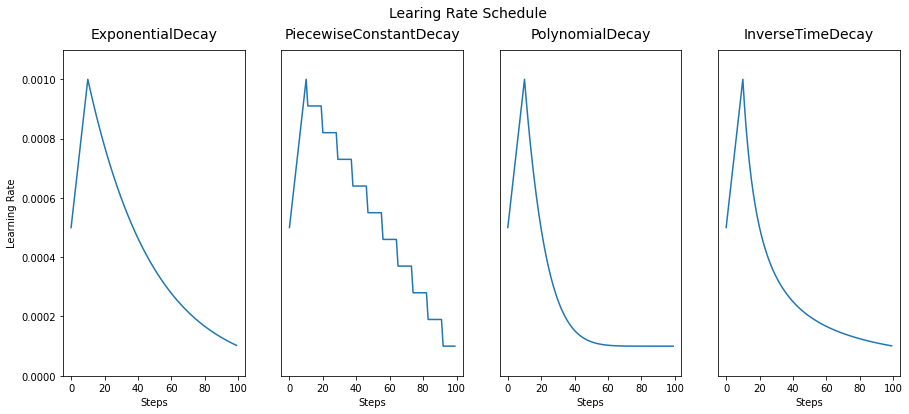

In [112]:
# Learning Rate Schedule Parameters
WARM_UP_FRACTION = 1/10 #The fraction of the training steps that will be ramping up linearly to the max LR
START_LR = 0.0005 # must be float
MAX_LR = 0.001 # must be float
END_LR = 0.0001 # must be float

EPOCHS = 100
STEPS_PER_EPOCH = 1
__TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH
__TOTAL_WARM_UP_STEPS = __TOTAL_STEPS * WARM_UP_FRACTION
__TOTAL_DECAY_STEPS = __TOTAL_STEPS - __TOTAL_WARM_UP_STEPS

#--------------------------------------------------------------------------------------------

# Decay Parameters
# ExponentialDecay - None

# PiecewiseConstantDecay
NUM_BOUNDARIES = 10
__BOUNDARY_STEP = __TOTAL_DECAY_STEPS/NUM_BOUNDARIES
__BOUNDARIES = list(np.arange(0,__TOTAL_DECAY_STEPS+__BOUNDARY_STEP,__BOUNDARY_STEP))
__PIECEWISE_STEP = (MAX_LR - END_LR)/(NUM_BOUNDARIES)
__VALUES = list(np.arange(MAX_LR,END_LR-__PIECEWISE_STEP,-__PIECEWISE_STEP))

# PolynomialDecay
POWER = 7 # Must be > 1 to reach END_LR

#InverseTimeDecay
__TIME_DECAY = __TOTAL_DECAY_STEPS/(MAX_LR/END_LR-1)

#--------------------------------------------------------------------------------------------
# Initialize Graphing
decay_array = ["ExponentialDecay", "PiecewiseConstantDecay", "PolynomialDecay", "InverseTimeDecay"]
x = range(__TOTAL_STEPS)

fig, ax = plt.subplots(figsize=(15, 6),ncols=len(decay_array))
fig.suptitle(f'Learing Rate Schedule', fontsize=14)
ymax = max(START_LR,MAX_LR,END_LR)
ymax *= 1.1


ax[0].set_ylabel('Learning Rate')
for i,decay_type in enumerate(decay_array):
    DECAY = decay_type
    lr_values = []
    for step in x:
      lr_values.append(lr_schedule(step,0))
    ax[i].plot(x,lr_values)
    ax[i].set_title(decay_type, fontsize=14, pad=11)
    ax[i].set_xlabel('Steps')
    ax[i].set_ylim([0,ymax])
    if i > 0:
        ax[i].tick_params(which='both', left=False, labelleft=False)
plt.show()
#--------------------------------------------------------------------------------------------

# ACTION: Select Decay Type
DECAY = "PiecewiseConstantDecay" #["ExponentialDecay", "PiecewiseConstantDecay", "PolynomialDecay", "InverseTimeDecay"]

In [14]:
class CustomLearningRateScheduler(keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule
        self.current_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        self.current_epoch += 1

    def on_batch_begin(self, batch_step, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        total_steps = batch_step + self.current_epoch * steps
        scheduled_lr = self.schedule(total_steps, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        # print("\nEpoch %05d: Learning rate is %6.4f." % (total_steps, scheduled_lr))

In [15]:
start_profile_batch = steps+10
stop_profile_batch = start_profile_batch + 100
profile_range = f"{start_profile_batch},{stop_profile_batch}"

log_path = log_dir + "/" + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1,
                                                     update_freq=20,profile_batch=profile_range)

checkpoint_filepath = save_path + "/" + "T5-{epoch:04d}-{val_loss:.4f}.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

callbacks = [tensorboard_callback, model_checkpoint_callback] 
if use_learning_schedule:
    callbacks.append(CustomLearningRateScheduler(lr_schedule))
metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5,name='accuracy') ]#[drop_eval.get_metrics]

#### Compile and run model

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
model.compile(optimizer=optimizer, metrics=metrics)
model.summary()

Model: "t5for_drop"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shared (TFSharedEmbeddings)  multiple                  16449536  
_________________________________________________________________
encoder (TFT5MainLayer)      multiple                  18881280  
_________________________________________________________________
decoder (TFT5MainLayer)      multiple                  25175808  
Total params: 60,506,630
Trainable params: 60,506,624
Non-trainable params: 6
_________________________________________________________________


In [17]:
%tensorboard --logdir $log_dir

Reusing TensorBoard on port 6006 (pid 1106), started 1:02:40 ago. (Use '!kill 1106' to kill it.)

<IPython.core.display.Javascript object>

In [18]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

if train_model:
    model.fit(tf_train_ds, epochs=epochs, steps_per_epoch=steps, callbacks=callbacks, 
              validation_data=tf_valid_ds, validation_steps=valid_steps,verbose=1)
    if(save_model):
        model.save_pretrained(save_path)
        print('Training complete, model saved')

Epoch 1/3

WARM UP: Using Increasing Linear Function at Training Step:0

Epoch 00000: Learning rate is 0.0000.
  1/125 [..............................] - ETA: 42:04 - accuracy: 0.0926 - loss: 13.4933 - F1: 0.1201 - EM: 0.0000e+00 - lr: 1.0000e-05
WARM UP: Using Increasing Linear Function at Training Step:1

Epoch 00001: Learning rate is 0.0000.
  2/125 [..............................] - ETA: 1:27 - accuracy: 0.1019 - loss: 13.3390 - F1: 0.1329 - EM: 0.0000e+00 - lr: 2.3200e-05 
WARM UP: Using Increasing Linear Function at Training Step:2

Epoch 00002: Learning rate is 0.0001.
  3/125 [..............................] - ETA: 56s - accuracy: 0.1073 - loss: 13.2678 - F1: 0.1370 - EM: 0.0000e+00 - lr: 3.6400e-05 
WARM UP: Using Increasing Linear Function at Training Step:3

Epoch 00003: Learning rate is 0.0001.
  4/125 [..............................] - ETA: 46s - accuracy: 0.1128 - loss: 13.0179 - F1: 0.1216 - EM: 0.0000e+00 - lr: 4.9600e-05
WARM UP: Using Increasing Linear Function at Tra

Epoch 2/3

Epoch 00125: Learning rate is 0.0009.
  1/125 [..............................] - ETA: 33s - accuracy: 0.9792 - loss: 0.1944 - F1: 0.3788 - EM: 0.0000e+00 - lr: 9.0000e-04
Epoch 00126: Learning rate is 0.0009.
  2/125 [..............................] - ETA: 26s - accuracy: 0.9826 - loss: 0.1699 - F1: 0.4598 - EM: 0.0000e+00 - lr: 9.0000e-04
Epoch 00127: Learning rate is 0.0009.
  3/125 [..............................] - ETA: 26s - accuracy: 0.9846 - loss: 0.1591 - F1: 0.5460 - EM: 0.0000e+00 - lr: 9.0000e-04
Epoch 00128: Learning rate is 0.0009.
  4/125 [..............................] - ETA: 25s - accuracy: 0.9844 - loss: 0.1596 - F1: 0.5840 - EM: 0.0000e+00 - lr: 9.0000e-04
Epoch 00129: Learning rate is 0.0009.
  5/125 [>.............................] - ETA: 25s - accuracy: 0.9838 - loss: 0.1553 - F1: 0.5980 - EM: 0.0000e+00 - lr: 9.0000e-04
Epoch 00130: Learning rate is 0.0009.
  6/125 [>.............................] - ETA: 24s - accuracy: 0.9838 - loss: 0.1563 - F1: 0.60

KeyboardInterrupt: ignored

In [ ]:
if load_model:
    model.load_weights(save_path+'/tf_model.h5')
    print(f'Model loaded from {save_path}')

#### Predict & Evaluate

In [ ]:
def batch_predict(ds,model,tokenizer):
    preds = []

    with tqdm(total=batch_size*len(list(ds.as_numpy_iterator()))) as bar:
        for batch in ds:
            input_ids = batch['input_ids']
            output = model.generate(input_ids)

            for i in range(output.shape[0]):
                single_pred = tokenizer.decode(output[i])
                single_pred = single_pred.replace('<pad>','')
                single_pred = single_pred.replace('</s>','')
                single_pred = single_pred.strip()
                single_pred = re.sub(r'(\d)\s+(\d)', r'\1\2', single_pred)
                preds.append(single_pred)
                bar.update(1)
    return preds

def evaluate(df):
    EM = []
    F1 = []
    
    if dataset == 'drop': 
        col = 'answers_spans'
        gold_col = 'spans'
    else:
        col = 'answers'
        gold_col = 'text'
    for predicted,gold in tqdm(zip(df['predicted'],df[col])):

        best_EM = 0
        best_F1 = 0

        for potential_answer in gold[gold_col]:
            metrics = drop_eval.get_metrics(predicted=predicted,gold=potential_answer)

            if metrics[1] > best_F1:
                best_EM = metrics[0]
                best_F1 = metrics[1]

        EM.append(best_EM)
        F1.append(best_F1)
        
    df['EM'] = EM
    df['F1'] = F1
    
    print('Exact Match: {:0.4f}, F1: {:0.4f}'.format(df.EM.mean(),df.F1.mean()))
    return df


In [ ]:
if predict_train:
    print('Making Train Predictions...')
    preds = batch_predict(ds=tf_train_ds,model=model,tokenizer=tokenizer)
    train_df = train_dataset.to_pandas()
    assert len(train_df) == len(preds), "count mismatch, something went wrong"
    train_df['predicted'] = preds
    print('Evaluating Train Predictions...')
    train_df = evaluate(train_df)
    if save_results:
        train_df.to_pickle(results_dir+'{}_train'.format(dataset)+datetime.datetime.now().strftime('%H%M-%h%d')+'.pkl')
        print('results for predictions on the training data saved to:\n',results_dir)
    
if predict_dev:
    print('Making Dev Predictions...')
    preds = batch_predict(ds=tf_valid_ds,model=model,tokenizer=tokenizer)
    valid_df = valid_dataset.to_pandas()
    valid_df['predicted'] = preds
    assert len(valid_df) == len(preds), "count mismatch, something went wrong"
    print('Evaluating Dev Predictions...')
    valid_df = evaluate(valid_df)
    if save_results:
        valid_df.to_pickle(results_dir+'{}_validation'.format(dataset)+datetime.datetime.now().strftime('%H%M-%h%d')+'.pkl')
        print('results for predictions on the validation data saved to:\n',results_dir)    
 

In [ ]:
valid_df.head()

In [ ]:
            __PIECEWISE_STEP = (MAX_LR - END_LR)/NUM_BOUNDARIES
            __VALUES = list(np.arange(MAX_LR-__PIECEWISE_STEP,END_LR,__PIECEWISE_STEP))valid_df[['query_id','passage','question','answers_spans','predicted','EM','F1']].sample(10)

In [ ]:
def print_example(query_id,df):
    print('question: ',df.loc[df.query_id == query_id,'question'].iloc[0])
    print('passage: ',df.loc[df.query_id == query_id,'passage'].iloc[0])
    print('\npredicted answer: ',df.loc[df.query_id == query_id,'predicted'].iloc[0])
    print('True answers: ',df.loc[df.query_id == query_id,'answers_spans'].iloc[0])
    print('F1 score: ',df.loc[df.query_id == query_id,'F1'].iloc[0])
    print('EM score: ',df.loc[df.query_id == query_id,'EM'].iloc[0])
    
    
query_id = '0686d1f9-4a8e-4031-b665-49d425afb777'
print_example(query_id,valid_df)

In [ ]:
query_id = '86dd1721-6bf4-45fa-b01e-de47e4f7301d'
print_example(query_id,valid_df)

In [ ]:
query_id = 'ad19857f-cd76-4d01-ba29-1a589cfee053'
print_example(query_id,valid_df)

In [ ]:
model.summary()

# Cells to explore the model a bit

(make these raw cells into code cells to explore)